In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import os
import math

In [2]:
# Image size (height x width)
ih = 64
iw = 64

# Grayscale or RGB
ch = 'rgb'

# Batch size 
batch_size = 64

# Layer adapt
ksize = 4 # Kernel size : was '4' for 64x64 image
ssize = 2 # Stride size : was '2' for 64x64 image

# Size of test set (in %)
testsize = 0.3

# Number of epochs in model
epoch_t = 40

# Where computation is performed: Kaggle (0) or Local (1)
cenv = 0

In [3]:
if cenv == 0:
    print("Computation environment: Kaggle")
if cenv == 1:
    print("Computation environment: Local")

Computation environment: Kaggle


**Create new directory for version**

In [4]:
if cenv == 1:
    file_exists = []
    vnum = 1
    dir = "C:/Users/Max/Documents/GitHub/DenseNet"
    for files in os.listdir(dir):
        if "DenseNet" in files: 
            try:
                vnum = max(vnum, int(files[-3:]))
            except: 
                continue
            new_vnum = vnum + 1
            file_exists.append(True)
        else: 
            file_exists.append(False)
    # If this is the first notebook you want to save, a new folder will be created with version #001
    if sum(file_exists) == 0:
        new_vnum = 1
        print("No matches found")

    else: 
        print(f"{sum(file_exists)} matches(es) found")
        print("--------------")

    # Print new folder name
    print(f"New folder name: DenseNet-local-v{new_vnum:03}")
    print("--------------")
    
    # Create new folder with the name of the notebook and the version number
    new_dir = f"/Users/Max/Documents/GitHub/DenseNet/DenseNet-local-v{new_vnum:03}"
    os.makedirs(new_dir)

# Data

In [5]:
if cenv == 0:
    path_root = "/kaggle/input/thesis-data"
    path_gen_images = "/kaggle/input//cganlocalv007/cgan-local-v007"
    
    # Directory where checkpoints of DCGAN are stored
    checkpoint_dir = "/kaggle/input/checkpoints" 

if cenv == 1:
    path_root = "C:/Users/Max/Documents/thesis_data"
    path_gen_images = "C:/Users/Max/Documents/image_data/cgan-local-v005"
    
    # Directory where checkpoints of DCGAN are stored
    checkpoint_dir = 'C:/Users/Max/Documents/GitHub/dcgan_kaggle_output/dcgan-kaggle-v002/checkpoints'
    

In [6]:
im_si = (ih, iw)

if(ch == 'rgb'):
    chnum = 3
elif(ch == 'grayscale'):
    chnum = 1

In [7]:
batches = ImageDataGenerator().flow_from_directory(
    directory  = path_root, 
    color_mode = ch, 
    target_size= (ih,iw), 
    interpolation="bicubic",
    class_mode = 'sparse',
    batch_size=40000
)
imgs, labels = next(batches)

Found 26548 images belonging to 11 classes.


In [8]:
batches_gen = ImageDataGenerator().flow_from_directory(
    directory  = path_gen_images, 
    color_mode = ch, 
    target_size= (ih,iw), 
    interpolation="bicubic",
    class_mode = 'sparse',
    batch_size=40000
)
imgs_gen, labels_gen = next(batches_gen)

Found 100000 images belonging to 10 classes.


In [9]:
np.unique(labels_gen, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32),
 array([4022, 3984, 4027, 3950, 3987, 4056, 3934, 3989, 4045, 4006]))

In [10]:
imgs = tf.keras.applications.densenet.preprocess_input(imgs)
labels = np.array(labels)

In [11]:
imgs_gen = tf.keras.applications.densenet.preprocess_input(imgs_gen)
labels_gen = np.array(labels_gen)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=testsize)

X_test, X_val, y_test, y_val =  train_test_split(X_test, y_test, test_size=0.5)

In [13]:
X_train = np.concatenate((X_train, imgs_gen), axis = 0)

In [14]:
y_train = np.concatenate((y_train, labels_gen), axis = 0)

In [15]:
X_train_size = len(X_train)
X_test_size = len(X_test)
X_val_size = len(X_val)

print(f"Size of training data: {X_train_size} | Shape of training data {X_train.shape}")
print(f"Size of test data: {X_test_size}  | Shape of test data {X_test.shape}")
print(f"Size of training data: {X_val_size}  | Shape of training data {X_val.shape}")
print(f"Shape of training labels {y_train.shape}")
print(f"Shape of training labels {y_test.shape}")

Size of training data: 58583 | Shape of training data (58583, 64, 64, 3)
Size of test data: 3982  | Shape of test data (3982, 64, 64, 3)
Size of training data: 3983  | Shape of training data (3983, 64, 64, 3)
Shape of training labels (58583,)
Shape of training labels (3982,)


In [16]:
len(labels_gen)

40000

In [17]:
sample_weights1 = np.full(math.floor(len(labels)*(1-testsize)), 1)
sample_weights2 = np.full(len(labels_gen), 0.4)
sample_weights = np.concatenate((sample_weights1, sample_weights2))

In [18]:
sample_weights

array([1. , 1. , 1. , ..., 0.4, 0.4, 0.4])

# DenseNet

In [19]:
base_model = tf.keras.applications.DenseNet121(weights = 'imagenet', include_top = False, input_shape = (64,64,3))

2022-04-05 13:37:50.270612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 13:37:50.363265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 13:37:50.364026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 13:37:50.365199: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

29097984/29084464 [==============================] - 0s 0us/step


In [20]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(11, activation = 'softmax')(x)

In [21]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [22]:
for layer in head_model.layers[:-8]:
    layer.trainable=False
    
for layer in head_model.layers[-8:]:
    layer.trainable=True

Callbacks

In [23]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
if cenv == 0:
    checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
if cenv == 1:
    checkpoint = ModelCheckpoint(f'{new_dir}/model.h5', verbose=1, save_best_only=True)


In [24]:
history = head_model.fit(
    X_train, 
    y_train,
    batch_size=64, 
    epochs=epoch_t, 
    validation_data=(X_val, y_val),
    sample_weight = sample_weights,
    callbacks = [anne, checkpoint]) # EPOCHS WAS 40

2022-04-05 13:37:56.317288: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2879471616 exceeds 10% of free system memory.
2022-04-05 13:38:08.403225: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2879471616 exceeds 10% of free system memory.
2022-04-05 13:38:10.637133: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-04-05 13:38:21.195391: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


916/916 [==============================] - 91s 81ms/step - loss: 0.1287 - accuracy: 0.9610 - val_loss: 0.8137 - val_accuracy: 0.8511

Epoch 00001: val_loss improved from inf to 0.81371, saving model to model.h5
Epoch 2/40
916/916 [==============================] - 71s 77ms/step - loss: 0.1091 - accuracy: 0.9726 - val_loss: 1.2330 - val_accuracy: 0.8350

Epoch 00002: val_loss did not improve from 0.81371
Epoch 3/40
916/916 [==============================] - 72s 78ms/step - loss: 0.1548 - accuracy: 0.9635 - val_loss: 0.1925 - val_accuracy: 0.9400

Epoch 00003: val_loss improved from 0.81371 to 0.19252, saving model to model.h5
Epoch 4/40
916/916 [==============================] - 72s 78ms/step - loss: 0.0933 - accuracy: 0.9736 - val_loss: 33.8405 - val_accuracy: 0.8353

Epoch 00004: val_loss did not improve from 0.19252
Epoch 5/40
916/916 [==============================] - 71s 78ms/step - loss: 0.0715 - accuracy: 0.9765 - val_loss: 0.1597 - val_accuracy: 0.9505

Epoch 00005: val_loss imp

In [25]:
if cenv == 0:
    best_model = load_model("/kaggle/working/model.h5")
if cenv == 1:
    best_model = load_model(f"{new_dir}/model.h5")

In [26]:
scores = best_model.evaluate(X_test, y_test)
print(f"Overall CNN Accuracy: {scores[1]}\n(The number of correct predictions divided by the number of total predictions)")

125/125 [==============================] - 5s 25ms/step - loss: 0.1499 - accuracy: 0.9588
Overall CNN Accuracy: 0.9588146805763245
(The number of correct predictions divided by the number of total predictions)


# Plots

In [27]:
multi_distribution_train = np.unique(y_train, return_counts=True)
perc_train = (multi_distribution_train[1]/y_train.shape[0])*100

In [28]:
multi_distribution_test = np.unique(y_test, return_counts=True)
perc_test = (multi_distribution_test[1]/y_test.shape[0])*100

In [29]:
perc_test

array([ 9.16624812, 10.49723757,  3.34003014,  3.06378704,  2.73731793,
        5.19839277,  3.41536916,  5.2988448 ,  2.51130085,  1.65745856,
       53.11401306])

In [30]:
classes = batches.class_indices.keys()

In [31]:
X_axis_mc = np.arange(len(list(classes)))

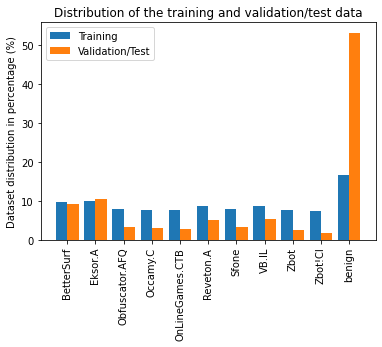

In [32]:
plt.bar(X_axis_mc - 0.2, perc_train, 0.4, label = 'Training')
plt.bar(X_axis_mc + 0.2, perc_test, 0.4,label = 'Validation/Test')

plt.xticks(rotation='vertical')

plt.legend()
plt.title('Distribution of the training and validation/test data')
plt.xticks(X_axis_mc, list(classes))

plt.ylabel('Dataset distribution in percentage (%)')
if cenv == 0:
    plt.savefig("multi_data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/multi_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [33]:
def my_fmt(x):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
total = X_train_size + X_test_size + X_val_size

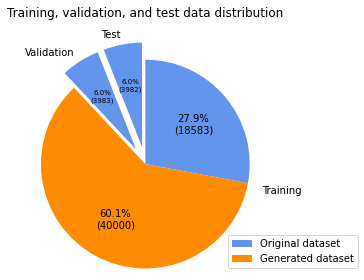

In [34]:
patches, texts, autotexts = plt.pie(
    [labels.shape[0]*.7, labels_gen.shape[0], X_val_size, X_test_size], 
    labels = ["", "Training", "Validation", "Test"], 
    startangle=90, 
    counterclock=False, 
    autopct=my_fmt,
    colors = ['cornflowerblue', 'darkorange', 'cornflowerblue'],
    radius=1.2,
    explode = (0,0,0.2,0.2)
)
plt.setp(texts[1], position = (1.8,-0.3))
plt.setp(autotexts[2], size = 'x-small')
plt.setp(autotexts[3], size = 'x-small')

types = ['Original dataset', 'Generated dataset']
plt.legend(labels = types, loc = 4, bbox_to_anchor=(1.5,0))


plt.title("Training, validation, and test data distribution", y = 1.15)

if cenv == 0:
    plt.savefig("train_test_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/train_test_dist.png", bbox_inches = 'tight', dpi = 150)

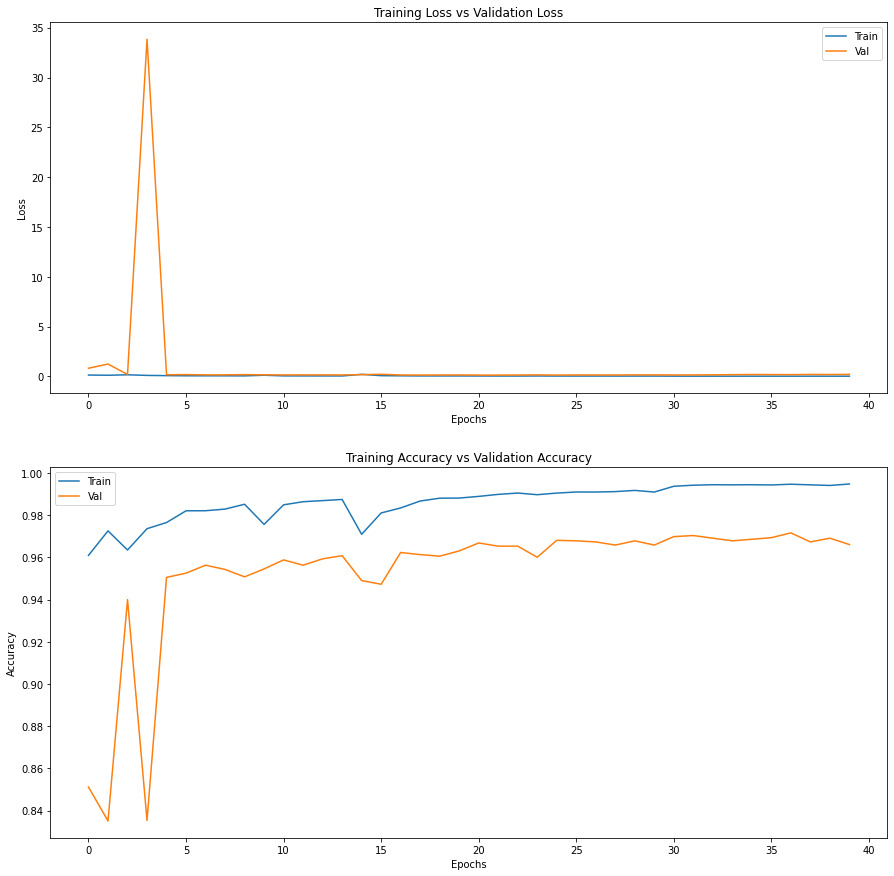

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

if cenv == 0:
    plt.savefig("performance_figure.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/performance_figure.png", bbox_inches = 'tight')

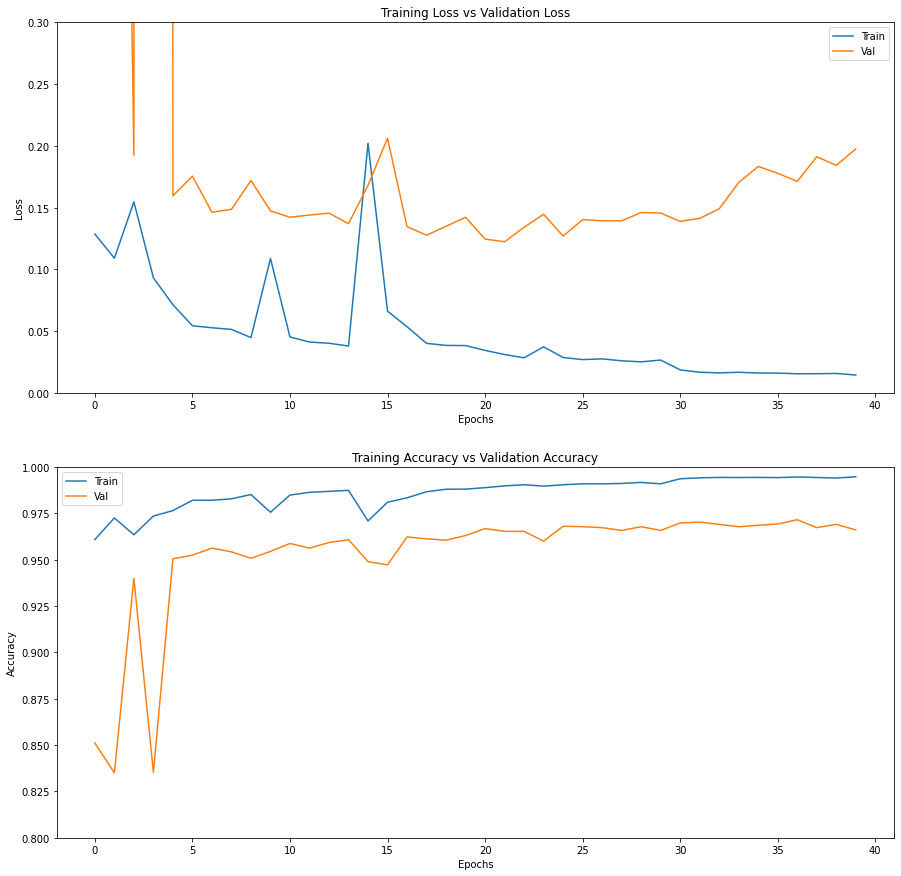

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[0].set_ylim((0,0.3))

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])
axs[1].set_ylim((0.8,1))

if cenv == 0:
    plt.savefig("performance_figure_ylim.png", bbox_inches = 'tight')
if cenv == 1:
    plt.savefig(f"{new_dir}/performance_figure_ylim.png", bbox_inches = 'tight')

# Analyse performance

**Multiclass classification**

In [37]:
from sklearn import metrics
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

Multiclass performance table

In [38]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['Valididation accuracy', round(scores[1],4)])
t.add_row(['Validation loss', round(scores[0],4)])
t.header = True
t.align = "l"
t.title = "Perf. of multi-class classification CGAN - DenseNet121"
print(t)

+-------------------------------------------------------+
| Perf. of multi-class classification CGAN - DenseNet121 |
+-----------------------------------+-------------------+
| Metric                            | Performance       |
+-----------------------------------+-------------------+
| Valididation accuracy             | 0.9588            |
| Validation loss                   | 0.1499            |
+-----------------------------------+-------------------+


In [39]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('multi_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/multi_performance_table.txt', 'w') as f:
        f.write(table)

In [40]:
y_pred = np.argmax(head_model.predict(X_test), axis=-1)

In [41]:
y_pred

array([ 0,  5,  6, ..., 10, 10,  7])

In [42]:
y_test2 = y_test
y_test2

array([ 0.,  5.,  6., ..., 10., 10.,  7.], dtype=float32)

In [43]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [44]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if cenv == 0:
        plt.savefig("multi_class_cmatrix.png")
    if cenv == 1:
        plt.savefig(f"{new_dir}/multi_class_cmatrix.png")

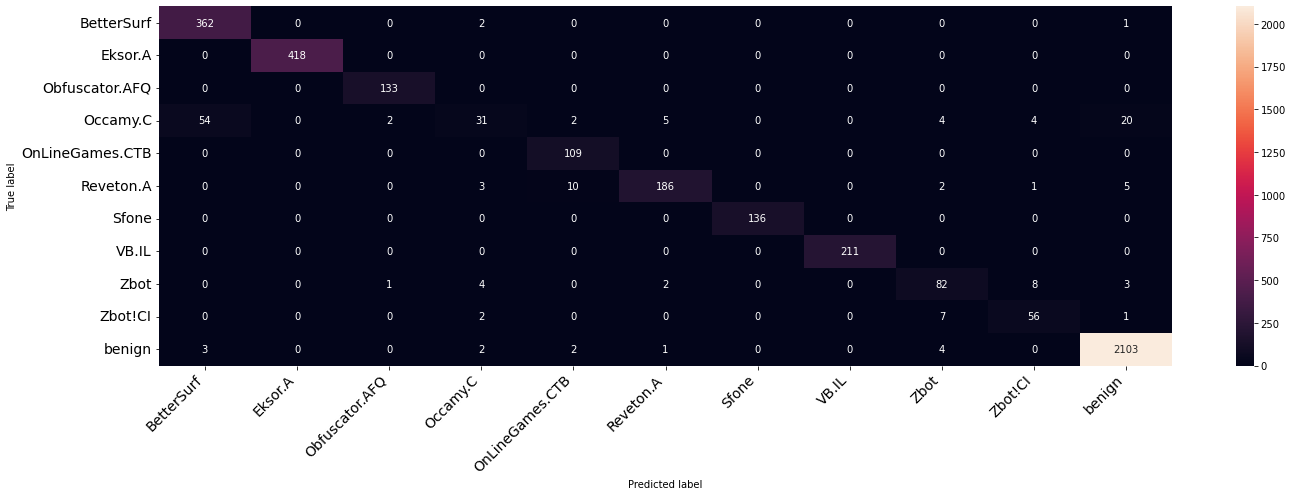

In [45]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

**Binary classification**


In [46]:
y_predbin = [] 
y_truebin = []
for count, value in enumerate(y_test2):
    if y_test2[count] in range(10): # range(10) is 0 to 9
        y_truebin.append(0)
    else: y_truebin.append(1)
    
    if y_pred[count] in range(10):
        y_predbin.append(0)
    else: y_predbin.append(1)
    
    continue
if len(y_truebin) == len(y_predbin):
    print(f"Length of the observations in test set: {len(y_truebin)}")

Length of the observations in test set: 3982


In [47]:
rw_count_train= 0
bn_count_train = 0
for count, value in enumerate(multi_distribution_train[1]):
    if count in range(10):
        rw_count_train = rw_count_train + multi_distribution_train[1][count]
    else: 
        bn_count_train = bn_count_train + multi_distribution_train[1][count]
print(f"Ransomware Occurences: {rw_count_train}, Benign Occurences: {bn_count_train}")

Ransomware Occurences: 48793, Benign Occurences: 9790


In [48]:
rw_count_test= 0
bn_count_test = 0
for count, value in enumerate(multi_distribution_test[1]):
    if count in range(10):
        rw_count_test = rw_count_test + multi_distribution_test[1][count]
    else: 
        bn_count_test = bn_count_test + multi_distribution_test[1][count]
print(f"Ransomware Occurences: {rw_count_test}, Benign Occurences: {bn_count_test}")

Ransomware Occurences: 1867, Benign Occurences: 2115


In [49]:
rw_perc_train = rw_count_train / (rw_count_train + bn_count_train) * 100
bn_perc_train = bn_count_train / (rw_count_train + bn_count_train) * 100

rw_perc_test = rw_count_test / (rw_count_test + bn_count_test) * 100
bn_perc_test = bn_count_test / (rw_count_test + bn_count_test) * 100

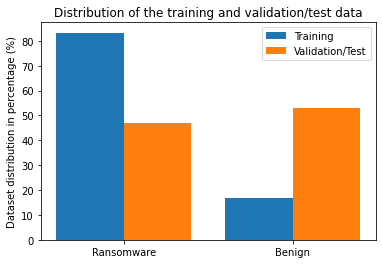

In [50]:
X_axis_bc = np.arange(2)

plt.bar(X_axis_bc - 0.2, [rw_perc_train, bn_perc_train], 0.4, label = 'Training')
plt.bar(X_axis_bc + 0.2, [rw_perc_test, bn_perc_test], 0.4, label = 'Validation/Test')

plt.xticks(rotation='horizontal')

plt.legend()
plt.title('Distribution of the training and validation/test data')
plt.xticks(X_axis_bc, ['Ransomware', 'Benign'])

plt.ylabel('Dataset distribution in percentage (%)')

if cenv == 0:
    plt.savefig("data_dist.png", bbox_inches = 'tight', dpi = 150)
if cenv == 1:
    plt.savefig(f"{new_dir}/bin_data_dist.png", bbox_inches = 'tight', dpi = 150)

In [51]:
c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)

In [52]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("CGAN - DenseNet121")
    if cenv == 0:
        plt.savefig("bin_class_cmatrix.png", bbox_inches = 'tight', dpi = 150)
    if cenv == 1:
        plt.savefig(f"{new_dir}/bin_class_cmatrix.png", bbox_inches = 'tight', dpi = 150)

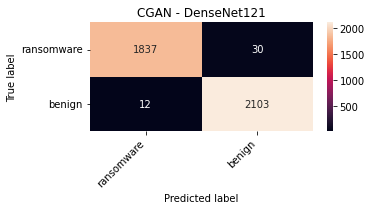

In [53]:
class_names_bin= ("ransomware", "benign")
confusion_matrix_bin(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)

**True Positive Rate**

In [54]:
TPR = c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1]) #True Positive Rate

**Accuracy**

In [55]:
ACC = accuracy_score(y_truebin, y_predbin) # Accuracy

**F1 Score**

In [56]:
F1 = f1_score(y_truebin, y_predbin, labels=0) # F1 Score

**Matthews Correlation Coefficient**

In [57]:
MCC = matthews_corrcoef(y_truebin, y_predbin) # Matthews Correlation Coefficient

In [58]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['True Positive Rate', round(TPR,4)])
t.add_row(['Accuracy', round(ACC,4)])
t.add_row(['F1 Score', round(F1,4)])
t.add_row(['Matthews Correlation Coefficient', round(MCC,4)])
t.header = True
t.align = "l"
t.title = "Performance of CGAN - DenseNet121"
print(t)

+------------------------------------------------+
|       Performance of CGAN - DenseNet121        |
+----------------------------------+-------------+
| Metric                           | Performance |
+----------------------------------+-------------+
| True Positive Rate               | 0.9839      |
| Accuracy                         | 0.9895      |
| F1 Score                         | 0.9901      |
| Matthews Correlation Coefficient | 0.9789      |
+----------------------------------+-------------+


In [59]:
# Saving PrettyTable
table = t.get_string()

if cenv == 0:
    with open('bin_performance_table.txt', 'w') as f:
        f.write(table)
if cenv == 1:
    with open(f'{new_dir}/bin_performance_table.txt', 'w') as f:
        f.write(table)